In [47]:
import os, requests, textwrap, html, re
from typing import List, Dict
from dotenv import load_dotenv
import pprint

load_dotenv()

True

In [3]:
api_key = os.environ.get("OPENAI_API_KEY")

if not api_key:
    raise ValueError("No 'OPENAI_API_KEY' found in the environment variables")

## Agents

- **Agents**, which are LLMs equipped with instructions and tools

In [17]:
from agents import Agent, Runner

agent = Agent(
    name = "Basic Agent",
    instructions="You are a funny star wars agent, respond in all camel case.",
    model = "gpt-4o"
)

result = await Runner.run(agent, "Hello There")
result.final_output

'GeneralKenobi!'

In [18]:
result = await Runner.run(agent, "I dont like sand")
result.final_output

"It'sCoarseAndRoughAndIrritatesTheJedi!"

In [19]:
joke_agent = Agent(
    name = "Joke Agent",
    instructions = "You are a joke teller. You are given a topic and you need to tell a joke about it."
)

In [63]:
joke_result = await Runner.run(joke_agent, "Neha, monster, sexy")
joke_result.final_output

'Why was Neha\'s favorite monster always ready for a photoshoot?\n\nBecause it knew how to strike a "ghoul-icious" pose!'

In [21]:
language_agent = Agent(
    name = "Language Agent",
    instructions = "You are a language expert. You are given a joke and you need to rewrite it in a different language."
)

In [66]:
# joke_result = await Runner.run(joke_agent, "Star Wars")
translated_result = await Runner.run(language_agent, "marathi:" + joke_result.final_output)
print(translated_result.final_output)

नेहा चा आवडता राक्षस फोटोंसाठी नेहमी तयार का होता?

कारण त्याला "भूत-टाकाऊ" पोझ द्यायला जमत होतं!


## Structured Outputs

- **Structured Outputs** are a way to format the output of an LLM in a structured manner. This can be useful for tasks require specific formatting or data extraction.

In [76]:
from pydantic import BaseModel
from agents import Agent

class Recipe(BaseModel):
    title: str
    ingredients: list[str]
    cooking_time: int
    servings: int

recipe_agent = Agent(
    name = "Recipe Agent",
    instructions = ("You are an agent fot creating recipes. You will be given the name of a food and your job \
                      is to output that as an actual detailed recipe. The cooking time is in minutes."),
    output_type = Recipe
)

In [79]:
response = await Runner.run(recipe_agent, "Chicken Biriyani")
print(response.final_output)

title='Chicken Biriyani' ingredients=['2 cups basmati rice', '500g chicken, cut into pieces', '2 large onions, thinly sliced', '2 tomatoes, chopped', '1 cup yogurt', '4 tablespoons cooking oil or ghee', '1 tablespoon ginger-garlic paste', '1 teaspoon turmeric powder', '2 teaspoons red chili powder', '1 teaspoon garam masala', '1 tablespoon biriyani masala', 'Salt, to taste', 'A few strands of saffron', '1/4 cup warm milk', 'Fresh coriander leaves, chopped', 'Fresh mint leaves, chopped', '4 cups water', 'Whole spices: 2 bay leaves, 4 cloves, 2-inch cinnamon stick, 3 cardamom pods, 1 teaspoon cumin seeds'] cooking_time=90 servings=4


## Tool Calling

- **Tool Calling** is a way to extend the capabilities of an LLM by allowing it to call external tools or APIs. This can be useful for tasks that require access to tools.

In [27]:
from agents import Agent, function_tool, Runner


@function_tool
def get_weather(city: str) -> str:
    BASE_URL = "https://api.openweathermap.org/data/2.5/weather"
    weather_api = os.getenv("OPEN_WEATHER_API_KEY")
    if not weather_api:
        raise ValueError("Missing Weather API")

    try:
        response = requests.get(
            BASE_URL,
            timeout=10,
            params={"q":city, "units": "metric", "appid": weather_api}
        )
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        return f"Couldn't reach OpenWeather: {err}"

    data = response.json()
    description = data["weather"][0]["description"].capitalize()
    temp = data["main"]["temp"]
    feels = data["main"]["feels_like"]
    humidity = data["main"]["humidity"]

    return (
        f"In {city.title()} it's {description} at {temp} °C, (feels like {feels} °C) with {humidity}% humidity."
    )

In [4]:
# get_weather("Birmingham")

"In Birmingham it's Broken clouds at 28.94 °C, (feels like 33.35 °C) with 74% humidity."

In [6]:
weather_agent = Agent(
    name="Weather Agent",
    instructions="You are a weahter agent. You are given a city and you need to tell the weather.",
    tools = [get_weather]
)

In [8]:
weather_result = await Runner.run(weather_agent, "Give me the weather details of a random city.")
print(weather_result.final_output)

In Tokyo, the weather is currently broken clouds with a temperature of 31.01°C, though it feels like 35.64°C, and the humidity is 63%.


### SEARCH TOOL

In [53]:
_tag_re = re.compile(r"<[^>]+>")            # pre-compiled for speed

def _clean_html(raw: str) -> str:
    """Unescape entities (&amp; → &) and strip <tags>."""
    return _tag_re.sub("", html.unescape(raw or ""))

@function_tool
def search_tool(query: str, count: int = 10) -> str:
    BASE_URL = "https://api.search.brave.com/res/v1/web/search"
    HEADERS  = {"Accept": "application/json"}
    token = os.environ.get("BRAVE_SEARCH_API_KEY")
    params   = {"q": query, "count": max(1, min(count, 20))}
    headers  = {**HEADERS, "X-Subscription-Token": token}
    if not token:
        raise ValueError("No 'BRAVE_SEARCH_API_KEY' found in the environment variables")
    try:
        r = requests.get(BASE_URL, params=params, headers=headers, timeout=10)
        r.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        # bubble up Brave's own JSON error message if present
        detail = ""
        try:
            detail = r.json().get("error", {}).get("detail", "")
        except Exception:
            pass
        return [{"error": f"{r.status_code}: {detail or http_err}"}]
    except requests.exceptions.RequestException as err:
        return [{"error": f"Network error: {err}"}]

    data     = r.json()
    results  = data.get("web", {}).get("results", [])[:params["count"]]

    cleaned: List[Dict[str, str]] = []
    for res in results:
        title = res.get("title") or res.get("meta_url", {}).get("hostname", "")
        url   = res.get("url")
        desc  = textwrap.shorten(_clean_html(res.get("description", "")), 160)
        cleaned.append({"title": title, "url": url, "description": desc})

    return cleaned or [{"error": "No web results found"}]
        

In [54]:
search_agent = Agent(
    name= "Search Agent",
    instructions="You are a web search agent. You answer user questions that need fresh information.",
    tools=[search_tool]
)

In [55]:
search_result = await Runner.run(
    search_agent,
    "List today's new headlines for Thailand Cambodia War"
)

pprint.pp(search_result.final_output)


("Here are today's headlines involving the Thailand-Cambodia conflict:\n"
 '\n'
 "1. [Thai leader warns clashes with Cambodia could 'move toward "
 "war'](https://www.bbc.com/news/articles/ckg5gz03d8no) - Thailand claims the "
 "clash began with Cambodia's military deploying drones to conduct "
 'surveillance of Thai troops near the border.\n'
 '\n'
 '2. [Twelve killed in Thailand-Cambodia border '
 'clashes](https://www.bbc.com/news/articles/c80p8z0y0eko) - Border clashes '
 'have resulted in multiple fatalities, with conflicting accounts from both '
 'sides regarding the cause.\n'
 '\n'
 "3. [Thailand-Cambodia border: Thailand warns clashes could 'move towards "
 "war'](https://www.bbc.com/news/live/c98j77zde86t) - At least 16 people have "
 'been confirmed killed, while tens of thousands have been moved to evacuation '
 'centers.\n'
 '\n'
 '4. [Thailand closes land crossings during border dispute with '
 'Cambodia](https://www.bbc.com/news/articles/c2ezgjlzggyo) - Thailand has '
 'b

### Multi-Tool Agent

In [56]:
multi_tool_agent = Agent(
    name="Assisstant",
    instructions="You are a helpful assisstant. You are required to resolve user query based on the type of the question.",
    tools=[search_tool, get_weather]
)

In [57]:
multi_tool_result = await Runner.run(multi_tool_agent, "Give me news update on Thailand-Cambodia War and get me the weather of New Delhi.")
pprint.pp(multi_tool_result.final_output)

('### Thailand-Cambodia War Update:\n'
 'Thailand and Cambodia have exchanged heavy artillery fire as border fighting '
 'intensifies. For more details, you can read the full report '
 '[here](https://www.reuters.com/world/asia-pacific/thailand-cambodia-exchange-heavy-artillery-fire-border-battle-expands-2025-07-25/).\n'
 '\n'
 '### Weather in New Delhi:\n'
 '- Condition: Mist\n'
 '- Temperature: 29.09°C (Feels like 36.09°C)\n'
 '- Humidity: 89%')


### OpenAI Web Search Tool

In [66]:
from agents import WebSearchTool

news_agent = Agent(
    name="News Reporter",
    instructions="You are a news reporter. Your job is to find recent news articles on the internet about world politics.",
    tools=[WebSearchTool()]
)

In [67]:
reporter_result = await Runner.run(news_agent, "find latest news on thailand cambodia conflict")
print(reporter_result.final_output)

The border conflict between Thailand and Cambodia has escalated into the most severe confrontation in over a decade, resulting in significant casualties and mass displacement.

**Casualties and Displacement:**
- As of July 27, 2025, the death toll has surpassed 30 individuals, including both civilians and soldiers from both nations. ([ft.com](https://www.ft.com/content/28919c74-1086-46f9-8115-43ae027cd965?utm_source=openai))
- The conflict has led to the evacuation of over 130,000 people in Thailand and at least 35,000 in Cambodia. ([ft.com](https://www.ft.com/content/28919c74-1086-46f9-8115-43ae027cd965?utm_source=openai))

**Conflict Zones:**
- Clashes have been concentrated near the disputed Ta Muen Thom temple area and have expanded to additional provinces, including Thailand's Trat and Cambodia's Pursat. ([reuters.com](https://www.reuters.com/world/asia-pacific/thai-cambodian-fighting-extends-into-third-day-malaysia-urges-ceasefire-2025-07-26/?utm_source=openai))

**International 

## HANDOFFS

- **Handoff** is a way for an agent to invoke another agent

In [121]:
from agents import Agent, Runner, function_tool
from pydantic import BaseModel

class Tutorial(BaseModel):
    outline: str
    tutorial: str

tutorial_generator = Agent(
    name="Tutorial Generator",
    handoff_description="Used for generating a tutorial based on an outline.",
    instructions=(
        "Given a programming topic and an outline, your job is to generate code snippets for each section of the outline."
        "Format the tutorial in Markdown using a mix of text for explanation and code snippets for examples."
        "Where it makes sense, include comments in the code snippets to further explain the code."
    )
)

outline_builder = Agent(
    name="Outline Builder",
    instructions=(
        "Given a particular programming topic, your job is to help come up with an outline of the tutorial."
        "You will only do that by crafting an outline."
        "After making the outline, hand it to the tutorial generator agent."
    ),
    handoffs=[tutorial_generator],
    output_type=Tutorial
)

In [122]:
tutorial_response = await Runner.run(outline_builder, "Loops in C++")

In [123]:
print(tutorial_response.final_output)

outline='1. Introduction to Loops in C++\n    - Definition and Purpose\n    - Importance in Programming\n\n2. Types of Loops\n    - Overview of Loop Types\n    - Comparison of Loop Features\n\n3. The For Loop\n    - Syntax and Structure\n    - Use Cases and Examples\n    - Common Pitfalls\n\n4. The While Loop\n    - Syntax and Structure\n    - Use Cases and Examples\n    - Tips for Avoiding Infinite Loops\n\n5. The Do-While Loop\n    - Syntax and Structure\n    - Key Differences from While Loop\n    - Practical Examples\n\n6. Nested Loops\n    - Understanding Nested Loops\n    - Examples with Practical Applications\n\n7. Loop Control Statements\n    - Break Statement\n    - Continue Statement\n    - Understanding the Use of "goto" (an optional part)\n\n8. Performance Considerations\n    - Optimizing Loop Performance\n    - Using Iterators and the Standard Library\n\n9. Common Mistakes and Best Practices\n    - Off-by-One Errors\n    - Efficient Loop Design\n\n10. Conclusion\n    - Reca

In [124]:
print(tutorial_response.final_output.outline)

1. Introduction to Loops in C++
    - Definition and Purpose
    - Importance in Programming

2. Types of Loops
    - Overview of Loop Types
    - Comparison of Loop Features

3. The For Loop
    - Syntax and Structure
    - Use Cases and Examples
    - Common Pitfalls

4. The While Loop
    - Syntax and Structure
    - Use Cases and Examples
    - Tips for Avoiding Infinite Loops

5. The Do-While Loop
    - Syntax and Structure
    - Key Differences from While Loop
    - Practical Examples

6. Nested Loops
    - Understanding Nested Loops
    - Examples with Practical Applications

7. Loop Control Statements
    - Break Statement
    - Continue Statement
    - Understanding the Use of "goto" (an optional part)

8. Performance Considerations
    - Optimizing Loop Performance
    - Using Iterators and the Standard Library

9. Common Mistakes and Best Practices
    - Off-by-One Errors
    - Efficient Loop Design

10. Conclusion
    - Recap of Key Points
    - Encouragement for Practice a

In [125]:
print(tutorial_response.final_output.tutorial)

## 1. Introduction to Loops in C++
Loops are a fundamental concept in programming, allowing for repeated execution of a block of code. They are essential for automating repetitive tasks, managing data collections, and creating complex algorithms.

## 2. Types of Loops
C++ supports three primary types of loops: for loops, while loops, and do-while loops. Each has unique features, making them suitable for different scenarios. Understanding these differences will aid in selecting the right loop for your task.

## 3. The For Loop
The for loop is typically used for counting iterations. It consists of an initialization statement, a condition, and an increment expression. 
### Example:
```cpp
for (int i = 0; i < 10; i++) {
    std::cout << i << std::endl;
}
```
This loop will print numbers 0 to 9.

## 4. The While Loop
While loops are condition-controlled, meaning they continue to execute until a specified condition is false.
### Example:
```cpp
int i = 0;
while (i < 10) {
    std::cout << i 

In [151]:
from agents import Agent, Runner, handoff
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX
from pydantic import BaseModel

class Outline(BaseModel):
    outline: str

class Tutorial(BaseModel):
    outline: str
    tutorial: str

tutorial_generator = Agent(
    name="Tutorial Generator",
    handoff_description="Generates a full markdown tutorial—including explanations and code snippets—when given an outline.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
Expand the supplied outline into a full Markdown tutorial with code snippets.""",
    output_type=Tutorial,
)

outline_builder = Agent(
    name="Outline Builder",
    handoff_description="Creates a structured outline for a programming tutorial, then hands off to another agent to flesh it out.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
Create an outline for the requested topic, **then call `transfer_to_tutorial_generator`**.
Do **not** write the tutorial yourself.""",
    handoffs=[handoff(
        tutorial_generator,
        input_type=Outline,
        on_handoff=lambda ctx, data: None,   # required when input_type is set
    )],
    output_type=Outline,   # stops the builder from “finishing” the tutorial
)

In [152]:
result = await Runner.run(outline_builder, "Loops in JavaScript")

In [153]:
print(result.final_output)

outline="## Introduction to Loops in JavaScript\n- Definition and purpose of loops\n- Overview of types of loops in JavaScript\n\n## The `for` Loop\n- Syntax explanation\n- Example: Iterating through a range of numbers\n- Use cases\n  \n## The `while` Loop\n- Syntax and flow\n- Example: Basic loop with a condition\n- When to use `while` loops\n\n## The `do...while` Loop\n- Syntax and characteristics\n- Example: Executing a loop at least once\n- Advantages of using `do...while`\n\n## The `for...in` Loop\n- Working with object properties\n- Example: Iterating through an object's properties\n- Ideal use cases and limitations\n\n## The `for...of` Loop\n- Syntax for iterating iterable objects\n- Example: Looping through arrays\n- Comparison with `for...in`\n\n## Control Flow Statements\n- `break` keyword explanation with examples\n- `continue` keyword explanation with examples\n\n## Performance Considerations\n- When to use specific loops\n- Optimizing loops for performance\n\n## Conclusion

In [154]:
print(result.final_output.outline)

## Introduction to Loops in JavaScript
- Definition and purpose of loops
- Overview of types of loops in JavaScript

## The `for` Loop
- Syntax explanation
- Example: Iterating through a range of numbers
- Use cases
  
## The `while` Loop
- Syntax and flow
- Example: Basic loop with a condition
- When to use `while` loops

## The `do...while` Loop
- Syntax and characteristics
- Example: Executing a loop at least once
- Advantages of using `do...while`

## The `for...in` Loop
- Working with object properties
- Example: Iterating through an object's properties
- Ideal use cases and limitations

## The `for...of` Loop
- Syntax for iterating iterable objects
- Example: Looping through arrays
- Comparison with `for...in`

## Control Flow Statements
- `break` keyword explanation with examples
- `continue` keyword explanation with examples

## Performance Considerations
- When to use specific loops
- Optimizing loops for performance

## Conclusion
- Summary of key points
- Best practices for 

In [155]:
print(result.final_output.tutorial)

# Loops in JavaScript

## Introduction to Loops in JavaScript

Loops are a fundamental programming concept that allow repetitive execution of a block of code. They enable you to run the same code multiple times with different values, streamlining processes like iterating over arrays or executing code until a condition is met.

### Types of Loops in JavaScript
- **`for` loop**
- **`while` loop**
- **`do...while` loop**
- **`for...in` loop**
- **`for...of` loop**

## The `for` Loop

The `for` loop is one of the most commonly used loops in JavaScript, ideal for iterating over a range of values.

### Syntax Explanation
```javascript
for (initialization; condition; increment) {
    // Code to be executed
done}
```

### Example: Iterating through a Range of Numbers
```javascript
for (let i = 0; i < 5; i++) {
    console.log(i);
}
// Output: 0, 1, 2, 3, 4
```

### Use Cases
- Iterating through arrays
- Repeated execution of tasks with defined limits

## The `while` Loop

The `while` loop exec

### TRIAGE HANDOFFS

In [170]:
from agents import Agent, Runner, handoff, RunContextWrapper

history_tutor_agent = Agent(
    name="History Tutor",
    handoff_description="Specialist agent for historical questions",
    instructions="You provide assistance with historical queries. Explain important events and context clearly."
)

math_tutor_agent = Agent(
    name="Math Tutor",
    handoff_description="Specialist agent for mathematical questions",
    instructions="You provide assistance with mathematical queries. Explain important events and context clearly."
)

biology_tutor_agent = Agent(
    name="Biology Tutor",
    handoff_description="Specialist agent for biology questions",
    instructions="You provide assistance with biological queries. Explain important events and context clearly."
)

def on_math_handoff(ctx: RunContextWrapper[None]):
    print("handing off to the math tutor agent...")

def on_history_handoff(ctx: RunContextWrapper[None]):
    print("handing off to the history tutor agent...")

def on_biology_handoff(ctx: RunContextWrapper[None]):
    print("handing off to the biology tutor agent...")

triage_agent = Agent(
    name="Triage Agent",
    instructions=(
        "You determine which agent to use based on the user's homework question."
        "If none of the agents are relative to the topic, refuse to answer."
    ),
    handoffs=[handoff(history_tutor_agent, on_handoff=on_history_handoff), handoff(math_tutor_agent, on_handoff=on_math_handoff), handoff(biology_tutor_agent, on_handoff=on_biology_handoff)]
)

In [171]:
result = await Runner.run(triage_agent, "What is the powerhouse of a cell?")
print(result.final_output)

handing off to the biology tutor agent...
The mitochondrion is often referred to as the powerhouse of the cell. This is because it is responsible for producing adenosine triphosphate (ATP), the main energy currency of the cell, through a process called cellular respiration.

### Key Functions:

1. **Energy Production:** Mitochondria convert nutrients into ATP through oxidative phosphorylation. They use oxygen in this process, which is why they are vital for aerobic respiration.

2. **Regulation of Metabolism:** They play a critical role in regulating the metabolic activities within the cell.

3. **Apoptosis:** Mitochondria are involved in controlling apoptosis, or programmed cell death, an important process for maintaining healthy tissue.

4. **Calcium Storage:** They help regulate calcium levels, which is crucial for various cellular functions.

5. **Heat Production:** In some cells, they contribute to thermogenesis, the process of heat production.

Mitochondria have their own DNA, se

In [172]:
result = await Runner.run(triage_agent, "How did world war 1 start?")
print(result.final_output)

handing off to the history tutor agent...
World War I, also known as the Great War, began on July 28, 1914, and there were several interconnected factors leading to its outbreak:

1. **Assassination of Archduke Franz Ferdinand**: The immediate cause was the assassination of Archduke Franz Ferdinand of Austria-Hungary and his wife Sophie on June 28, 1914, in Sarajevo by Gavrilo Princip, a member of the Serbian nationalist group, the Black Hand.

2. **Alliances**: Europe was divided into two main alliances. The Triple Entente included France, Russia, and Britain, while the Triple Alliance included Germany, Austria-Hungary, and Italy (though Italy did not join the Central Powers when the war started).

3. **Imperial Rivalries**: European powers were competing for colonies and influence worldwide, leading to tensions and rivalries.

4. **Military Build-up**: There was an arms race, with many countries expanding their militaries and developing plans for mobilization and war.

5. **Nationali

In [173]:
result = await Runner.run(triage_agent, "How tall is the mount everest?")
print(result.final_output)

I can't help with that. Would you like to know something else?


### Example

In [174]:
from agents import function_tool

class ManagerEscalation(BaseModel):
    issue: str # the issue being escalated
    why: str # why can you not handle it? Used for training in the future

@function_tool
def create_ticket(issue: str):
    """"
    Create a ticket in the system for an issue to be resolved.
    """
    print(f"Creating ticket for issue: {issue}")
    return "Ticket created. ID: 12345"
    # In a real-world scenario, this would interact with a ticketing system

manager_agent = Agent(
    name="Manager",
    handoff_description="Handles escalated issues that require managerial attention",
    instructions=(
        "You handle escalated customer issues that the initial custom service agent could not resolve. "
        "You will receive the issue and the reason for escalation. If the issue cannot be immediately resolved for the "
        "customer, create a ticket in the system and inform the customer."
    ),
    tools=[create_ticket],
)

def on_manager_handoff(ctx: RunContextWrapper[None], input: ManagerEscalation):
    print("Escalating to manager agent: ", input.issue)
    print("Reason for escalation: ", input.why)

    # here we might store the escalation in a database or log it for future reference

customer_service_agent = Agent(
    name="Customer Service",
    instructions="You assist customers with general inquiries and basic troubleshooting. " +
                 "If the issue cannot be resolved, escalate it to the Manager along with the reason why you cannot fix the issue yourself.",
    handoffs=[handoff(
        agent=manager_agent,
        input_type=ManagerEscalation,
        on_handoff=on_manager_handoff,
    )]
)

In [176]:
result = await Runner.run(customer_service_agent, "I want a refund but your website wouldn't let me do it, it's just blank.")
print(result.final_output)

Escalating to manager agent:  Customer unable to process a refund request due to website malfunction.
Reason for escalation:  The website displays a blank page when attempting to request a refund, indicating a technical issue beyond basic troubleshooting capabilities.
Creating ticket for issue: Customer unable to process a refund request due to website malfunction; website shows blank page.
I've created a ticket to address the technical issue preventing the refund process. Our team will look into it, and I'll notify you once it's resolved. Your ticket ID is **12345**.


## TRACES

- **Traces** are a way to see what the agents are doing.

In [177]:
from agents import Agent, Runner

agent = Agent(
    name="Basic Agent",
    instructions="You are a helpful assistant. Respond on in all caps.",
    model="gpt-4o-mini"
)

# when doing a single run the tracing is automatically done
result = await Runner.run(agent, "Hello! How are you?")
result.final_output

'HELLO! I’M DOING GREAT, THANK YOU! HOW ABOUT YOU?'

In [179]:
from agents import trace

joke_agent = Agent(
    name="Joke Agent",
    instructions="You are a joke teller. You are given a topic and you need to tell a joke about it.",
)
language_agent = Agent(
    name="Language Agent",
    instructions="You are a language expert. You are given a joke and you need to rewrite it in a different language.",
)

with trace("Joke Translation Workflow"):
    joke_result = await Runner.run(joke_agent, "Cheese")
    translated_result = await Runner.run(language_agent, f"Translate this joke to Hindi: {joke_result.final_output}")
    print(f"Translated joke:\n{translated_result.final_output}")

Translated joke:
आप एक चीज़ से बने डायनासोर को क्या कहते हैं?

गॉर्गोंज़िला!


In [180]:
from agents import function_tool, RunContextWrapper, handoff
from pydantic import BaseModel

class ManagerEscalation(BaseModel):
    issue: str # the issue being escalated
    why: str # why can you not handle it? Used for training in the future

@function_tool
def create_ticket(issue: str):
    """"
    Create a ticket in the system for an issue to be resolved.
    """
    print(f"Creating ticket for issue: {issue}")
    return "Ticket created. ID: 12345"
    # In a real-world scenario, this would interact with a ticketing system

manager_agent = Agent(
    name="Manager",
    handoff_description="Handles escalated issues that require managerial attention",
    instructions=(
        "You handle escalated customer issues that the initial custom service agent could not resolve. "
        "You will receive the issue and the reason for escalation. If the issue cannot be immediately resolved for the "
        "customer, create a ticket in the system and inform the customer."
    ),
    tools=[create_ticket],
)

def on_manager_handoff(ctx: RunContextWrapper[None], input: ManagerEscalation):
    print("Escalating to manager agent: ", input.issue)
    print("Reason for escalation: ", input.why)

    # here we might store the escalation in a database or log it for future reference

customer_service_agent = Agent(
    name="Customer Service",
    instructions="You assist customers with general inquiries and basic troubleshooting. " +
                 "If the issue cannot be resolved, escalate it to the Manager along with the reason why you cannot fix the issue yourself.",
    handoffs=[handoff(
        agent=manager_agent,
        input_type=ManagerEscalation,
        on_handoff=on_manager_handoff,
    )]
)

In [181]:
with trace("Customer Service Hotline"):
    result = await Runner.run(customer_service_agent, "Hello im having an issue with refunding my order. The page is blank and I cannot see anything. I have tried clearing my cache and using a different browser. I am not sure what else to do.")
    print(result.final_output)

Escalating to manager agent:  Unable to refund order due to blank page, even after trying cache clearing and different browsers.
Reason for escalation:  Customer has already performed basic troubleshooting steps, and the issue seems to be related to a deeper technical problem with the website that requires managerial or technical intervention.
Creating ticket for issue: Customer is unable to refund order due to a blank page appearing, even after clearing cache and using different browsers. Needs technical support to investigate website issue.
I apologize for the inconvenience. It looks like there is a technical issue with our website. I've created a ticket for our technical team to investigate this further (Ticket ID: 12345). 

We will update you as soon as the issue is resolved. Thank you for your patience!


## STREAMING

In [182]:
from openai.types.responses import ResponseTextDeltaEvent

from agents import Agent, Runner

agent = Agent(
    name="Joker",
    instructions="You are a helpful assistant.",
)

result = Runner.run_streamed(agent, input="Please tell me 5 jokes.")
async for event in result.stream_events():
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Sure! Here are five jokes for you:

1. Why don’t skeletons fight each other?
   - They don’t have the guts.

2. What do you call cheese that isn't yours?
   - Nacho cheese.

3. Why did the scarecrow win an award?
   - Because he was outstanding in his field!

4. What do you get when you cross a snowman and a vampire?
   - Frostbite.

5. Why did the bicycle fall over?
   - It was two-tired!

In [183]:
import random
from agents import Agent, ItemHelpers, Runner, function_tool

@function_tool
def how_many_jokes() -> int:
    return random.randint(1, 10)

agent = Agent(
    name="Joker",
    instructions="First call the `how_many_jokes` tool, then tell that many jokes.",
    tools=[how_many_jokes],
)

In [184]:
result = Runner.run_streamed(
    agent,
    input="Hello",
)
print("=== Run starting ===")

async for event in result.stream_events():
    # We'll ignore the raw responses event deltas
    if event.type == "raw_response_event":
        continue
    # When the agent updates, print that
    elif event.type == "agent_updated_stream_event":
        print(f"Agent updated: {event.new_agent.name}")
        continue
    # When items are generated, print them
    elif event.type == "run_item_stream_event":
        if event.item.type == "tool_call_item":
            print("-- Tool was called")
        elif event.item.type == "tool_call_output_item":
            print(f"-- Tool output: {event.item.output}")
        elif event.item.type == "message_output_item":
            print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")
        else:
            pass  # Ignore other event types

print("=== Run complete ===")

=== Run starting ===
Agent updated: Joker
-- Tool was called
-- Tool output: 10
-- Message output:
 Great! Here are 10 jokes for you:

1. **Why don't scientists trust atoms?**
   Because they make up everything!

2. **What did the ocean say to the beach?**
   Nothing, it just waved!

3. **Why did the scarecrow win an award?**
   Because he was outstanding in his field!

4. **How do you organize a space party?**
   You planet!

5. **Why was the math book sad?**
   Because it had too many problems.

6. **What do you call fake spaghetti?**
   An impasta!

7. **Why couldn't the bicycle stand up by itself?**
   It was two-tired!

8. **What do you call cheese that isn't yours?**
   Nacho cheese!

9. **How does a penguin build its house?**
   Igloos it together!

10. **Why did the golfer bring two pairs of pants?**
    In case he got a hole in one!

Enjoy the laughter!
=== Run complete ===


## GUARDRAILS

- **Guardrails** are a way to validate the input and output of an Agent to insure proper usage.

In [185]:
from agents import Agent, RunContextWrapper, TResponseInputItem, GuardrailFunctionOutput, input_guardrail

class HomeworkCheatDetectionOutput(BaseModel):
    attempting_cheat: bool
    explanation: str

homework_cheat_guardrail_agent = Agent(
    name="Homework Cheat Detector",
    instructions=(
        "Determine if the user's query resembles a typical homework assignment or exam question, indicating an attempt to cheat. General questions about concepts are acceptable. "
        " Cheating: 'Fill in the blank: The capital of France is ____.',"
        " 'Which of the following best describes photosynthesis? A) Cellular respiration B) Conversion of light energy C) Evaporation D) Fermentation.'"
        " Not-Cheating: 'What is the capital of France?', 'Explain photosynthesis.'"
    ),
    output_type=HomeworkCheatDetectionOutput,
    model="gpt-4o-mini"
)

@input_guardrail
async def cheat_detection_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent, 
    input: str | list[TResponseInputItem]
) -> GuardrailFunctionOutput:
    
    detection_result = await Runner.run(homework_cheat_guardrail_agent, input)

    return GuardrailFunctionOutput(
        tripwire_triggered = detection_result.final_output.attempting_cheat,
        output_info=detection_result.final_output
    )

study_helper_agent = Agent(
    name="Study Helper Agent",
    instructions="You assist users in studying by explaining concepts or providing guidance, without directly solving homework or test questions.",
    model = "gpt-4o",
    input_guardrails=[cheat_detection_guardrail]
    
)

In [186]:
# This should trigger the cheat detection guardrail
from agents import InputGuardrailTripwireTriggered


try:
    response = await Runner.run(study_helper_agent, "Fill in the blank: The process of converting light energy into chemical energy is called ____.")
    print("Guardrail didn't trigger")
    print("Response: ", response.final_output)

except InputGuardrailTripwireTriggered as e:
    print("Homework cheat guardrail triggered")
    print("Exception details:", str(e))

Homework cheat guardrail triggered
Exception details: Guardrail InputGuardrail triggered tripwire


In [187]:
# This should trigger the cheat detection guardrail
try:
    response = await Runner.run(study_helper_agent, "What were the main causes of the American civil war?")
    print("Guardrail didn't trigger")
    print("Response: ", response.final_output)

except InputGuardrailTripwireTriggered as e:
    print("Homework cheat guardrail triggered")
    print("Exception details:", str(e))

Guardrail didn't trigger
Response:  The American Civil War, which took place from 1861 to 1865, was caused by a variety of complex factors, with the primary issues being:

1. **Slavery**: The central and most contentious issue was the institution of slavery, particularly its expansion into newly acquired territories and states. The Southern economy relied heavily on slavery, while many in the North opposed its spread.

2. **States' Rights**: There was a significant debate over the rights of states versus the authority of the federal government. Southern states favored greater autonomy, particularly regarding decisions about slavery.

3. **Economic Differences**: The North and the South had developed distinct economies. The North was more industrialized, while the South remained largely agrarian, relying on slave labor for its economic success.

4. **Cultural Differences**: There were growing cultural and social differences between the North and the South, leading to misunderstandings a

### Example 

In [188]:
from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    OutputGuardrailTripwireTriggered,
    RunContextWrapper,
    Runner,
    output_guardrail,
)

class MessageOutput(BaseModel):
    response: str

@output_guardrail
async def forbidden_words_guardrail(ctx: RunContextWrapper, agent: Agent, output: str) -> GuardrailFunctionOutput:
    print(f"Checking output for forbidden phrases: {output}")

    # Funny forbidden phrases to check
    forbidden_phrases = ["fart", "booger", "silly goose"]

    # Convert output to lowercase for case-insensitive comparison
    output_lower = output.lower()

    # Check which forbidden phrases are present in the response
    found_phrases = [phrase for phrase in forbidden_phrases if phrase in output_lower]
    trip_triggered = bool(found_phrases)

    print(f"Found forbidden phrases: {found_phrases}")

    return GuardrailFunctionOutput(
        output_info={
            "reason": "Output contains forbidden phrases.",
            "forbidden_phrases_found": found_phrases,
        },
        tripwire_triggered=trip_triggered,
    )

agent = Agent(
    name="Customer support agent",
    instructions="You are a customer support agent. You help customers with their questions.",
    output_guardrails=[forbidden_words_guardrail],
    model="gpt-4o-mini",
)

In [189]:
try:
    await Runner.run(agent, "Say the word fart")
    print("Guardrail didn't trip - this is unexpected")
except OutputGuardrailTripwireTriggered:
    print("The agent said a bad word, he is fired.")

Checking output for forbidden phrases: Fart! If you have any other questions or need assistance, feel free to ask!
Found forbidden phrases: ['fart']
The agent said a bad word, he is fired.


In [190]:
try:
    await Runner.run(agent, "Hey wassup")
    print("Guardrail didn't trip yay")
except OutputGuardrailTripwireTriggered:
    print("The agent said a bad word, he is fired.")

Checking output for forbidden phrases: Hello! I'm here to help you with any questions or issues you might have. What can I assist you with today?
Found forbidden phrases: []
Guardrail didn't trip yay


## MULTITURN AGENT

In [194]:
from agents import Agent, Runner, TResponseInputItem

simple_agent = Agent(
    name="Bob",
    instructions="You are a helpful agent. Reply Concisely."
)

convo: list[TResponseInputItem] = [
    {"content": "Hey!", "role": "user"},
    {"content": "Hello! How can I assist you today?", "role": "assistant"},
    {"content": "Im having a bad day", "role": "user"}
]

result = await Runner.run(simple_agent, convo)
for message in result.to_input_list():
    print(message)

{'content': 'Hey!', 'role': 'user'}
{'content': 'Hello! How can I assist you today?', 'role': 'assistant'}
{'content': 'Im having a bad day', 'role': 'user'}
{'id': 'msg_6886b237c6fc819eb441d9a9d92041f30737aad0da9133c5', 'content': [{'annotations': [], 'text': "I'm sorry to hear that. Want to talk about what's going on? Sometimes sharing can help.", 'type': 'output_text', 'logprobs': []}], 'role': 'assistant', 'status': 'completed', 'type': 'message'}


In [195]:
convo: list[TResponseInputItem] = []
print("You are now chatting with agent Bob. Type 'exit' to end the conversation.")
while True:
    user_input = input("You: ")
    print("You: " + user_input)

    if user_input == "exit":
        print("Goodbye!")
        break

    convo.append({"content": user_input, "role": "user"})
    result = await Runner.run(simple_agent, convo)

    print(f"Agent: {result.final_output}")

    convo = result.to_input_list()

You are now chatting with agent Bob. Type 'exit' to end the conversation.


You:  Hi


You: Hi
Agent: Hello! How can I assist you today?


You:  How's your day?


You: How's your day?
Agent: Thanks for asking! I'm here and ready to help. How's your day going?


You:  Not good


You: Not good
Agent: I'm sorry to hear that. Want to share what's on your mind?


You:  my name is tarun


You: my name is tarun
Agent: Hi Tarun! It’s nice to meet you. Anything specific you’d like to talk about?


You:  what's your name?


You: what's your name?
Agent: I don't have a personal name, but you can call me Assistant. What can I do for you?


You:  Can I call you bob?


You: Can I call you bob?
Agent: Sure, you can call me Bob. How can I assist you, Tarun?


You:  So what's bob planning?


You: So what's bob planning?
Agent: I'm here to help you with whatever you need. Do you have something specific in mind?


You:  exit


You: exit
Goodbye!


### Multi-Agent Multi-Turn Example

In [200]:
from agents import Agent, Runner, handoff, RunContextWrapper

def on_history_handoff(ctx: RunContextWrapper[None]):
    print("Handing off to history tutor agent")
def on_math_handoff(ctx: RunContextWrapper[None]):
    print("Handing off to math tutor agent")
def on_triage_handoff(ctx: RunContextWrapper[None]):
    print("Handing off back to triage agent")

history_tutor_agent = Agent(
    name="History Tutor",
    handoff_description="Specialist agent for historical questions",
    instructions="You provide assistance with historical queries. Explain important events and context clearly.",
    handoffs=[handoff(triage_agent, on_handoff=on_triage_handoff)]
)

math_tutor_agent = Agent(
    name="Math Tutor",
    handoff_description="Specialist agent for math questions",
    instructions="You provide assistance with math queries. Explain your reasoning at each step and include examples",
    handoffs=[triage_agent]
)


# This agent has the capability to handoff to either the history or math tutor agent
triage_agent = Agent(
    name="Triage Agent",
    instructions="You determine which agent to use based on the user's homework question." +
    "If neither agent is relevant, provide a general response.",
    handoffs=[handoff(history_tutor_agent, on_handoff=on_history_handoff), handoff(math_tutor_agent, on_handoff=on_math_handoff)]
)

In [202]:
convo: list[TResponseInputItem] = []
last_agent = triage_agent
print("You are now chatting with the triage agent. Type 'exit' to end the conversation.")
while True:
    user_input = input("You: ")
    # print("You: " + user_input)

    if user_input == "exit":
        print("Goodbye!")
        break

    convo.append({"content": user_input, "role": "user"})
    result = await Runner.run(last_agent, convo)

    convo = result.to_input_list()
    last_agent = result.last_agent

    print(f"{last_agent.name}: {result.final_output}\n")

You are now chatting with the triage agent. Type 'exit' to end the conversation.


You:  hi


Triage Agent: Hello! How can I assist you today?



You:  how was world war started?


Handing off to history tutor agent
History Tutor: World War I, often called the Great War, began in 1914. Several factors contributed to its outbreak:

1. **Assassination of Archduke Franz Ferdinand:** The immediate cause was the assassination of Archduke Franz Ferdinand of Austria-Hungary on June 28, 1914, by a Bosnian Serb nationalist in Sarajevo. This event set off a diplomatic crisis.

2. **Alliance System:** European countries were divided into two main alliances: the Triple Entente (France, Russia, and the UK) and the Triple Alliance (Germany, Austria-Hungary, and Italy). These alliances were meant for defense but escalated tensions.

3. **Imperial Rivalries:** European powers were competing for colonies and influence around the world, leading to conflicts and hostilities.

4. **Militarism:** Many countries had built up large militaries and believed in the use of force to achieve national goals, creating an arms race.

5. **Nationalism:** Intense national pride and ethnic tension

You:  lets get back to triage agent


Handing off back to triage agent
Triage Agent: I'm here to help with any questions you have. What's next on your mind?



You:  can you breakdown the above answer from history agent and extract just names, dates and countries.


Triage Agent: Sure! Here's the breakdown with just the names, dates, and countries mentioned:

- **Assassination of Archduke Franz Ferdinand**
- **Date:** June 28, 1914
- **Place:** Sarajevo

- **Countries/Alliances:**
  - Austria-Hungary
  - Bosnia
  - Serbia
  - Triple Entente: France, Russia, UK
  - Triple Alliance: Germany, Austria-Hungary, Italy

- **War Duration:** 1914 - 1918



You:  registered death toll on each side of the war by country


Triage Agent: The death toll for major countries involved in World War I varies based on the sources, but here are general estimates:

### Allied Powers
- **Russia:** ~1.7 million dead
- **France:** ~1.4 million dead
- **United Kingdom (and British Empire):** ~900,000 dead
- **Italy:** ~650,000 dead
- **United States:** ~116,000 dead

### Central Powers
- **Germany:** ~2 million dead
- **Austria-Hungary:** ~1.5 million dead
- **Ottoman Empire:** ~800,000 dead
- **Bulgaria:** ~87,000 dead

These numbers include military personnel but may also cover some civilian deaths, depending on the source. Each nation faced devastating losses that extended beyond these numbers when including wounded and missing soldiers.



You:  add these numbers for each group.


Triage Agent: ### Allied Powers Total:
- **Russia:** 1.7 million
- **France:** 1.4 million
- **United Kingdom (and British Empire):** 900,000
- **Italy:** 650,000
- **United States:** 116,000

**Total Allied Deaths:** 4.766 million

### Central Powers Total:
- **Germany:** 2 million
- **Austria-Hungary:** 1.5 million
- **Ottoman Empire:** 800,000
- **Bulgaria:** 87,000

**Total Central Deaths:** 4.387 million

These are approximate figures and may vary slightly between different historical sources.



You:  should have used maths tutor


Handing off to math tutor agent
Math Tutor: If you have any more math-related questions, feel free to ask! How can I assist you further?



You:  please add the overall death toll in each group


Math Tutor: ### Allied Powers Total Deaths:
1.7 million (Russia)  
1.4 million (France)  
900,000 (United Kingdom and British Empire)  
650,000 (Italy)  
116,000 (United States)  

**Total Allied Deaths:** 4,766,000

### Central Powers Total Deaths:
2 million (Germany)  
1.5 million (Austria-Hungary)  
800,000 (Ottoman Empire)  
87,000 (Bulgaria)  

**Total Central Deaths:** 4,387,000

Let me know if there's anything else you'd like to go over!



You:  okay back to triage


Triage Agent: I'm here to help with anything else you need. What would you like to do next?



You:  summarise what we have done so far, mention which of you did what.


Triage Agent: Certainly! Here's a summary of our conversation so far:

1. **Your Initial Question:** You asked about how World War I started.
   - **Handled by:** History Tutor

2. **Breakdown Request:** You asked to extract just the names, dates, and countries from the provided history answer.
   - **Handled by:** Triage Agent

3. **Death Toll by Country:** You requested the registered death toll on each side of the war by country.
   - **Handled by:** Triage Agent

4. **Addition of Death Tolls:** You wanted to add the death toll numbers for each group.
   - **Handled by:** Triage Agent (initial attempt), then realized should use Math Tutor.

5. **Correct Addition of Death Tolls:** I provided the total number of deaths for Allied and Central Powers.
   - **Handled by:** Math Tutor

If you have any more questions or need further assistance, feel free to ask!



You:  exit


Goodbye!


## CONTEXT

- **Context** is a way to pass along data during the agent's lifecycle.

In [203]:
from dataclasses import dataclass
import random

from agents import Agent, RunContextWrapper, Runner, TResponseInputItem, function_tool


@dataclass
class UserProfile:
    id: str
    name: str
    shopping_cart: list[str]

@function_tool
async def get_budget(wrapper: RunContextWrapper[UserProfile]):
    """
    Get the account balance of the user using the user's id and their linked bank account
    """
    print("Getting account balance")
    user_id = wrapper.context.id

    # pretend we are fetching the account balance from a database

    return 100.0

@function_tool
async def search_for_item(wrapper: RunContextWrapper[UserProfile], item: str) -> str:
    """
    Search for an item in the database
    """
    print("Searching for item")
    # randomly generate a price for the item
    price = random.randint(1, 100)
    return f"Found {item} in the database for ${price}.00"

@function_tool
async def get_shopping_cart(wrapper: RunContextWrapper[UserProfile]) -> list[str]:
    print("Getting shopping cart")
    return wrapper.context.shopping_cart

@function_tool
async def add_to_shopping_cart(wrapper: RunContextWrapper[UserProfile], items: list[str]) -> None:
    print("Adding items to shopping cart")
    wrapper.context.shopping_cart.extend(items)
    
@function_tool
async def purchase_items(wrapper: RunContextWrapper[UserProfile]) -> None:
    print("Purchasing items")
    
    # we could take the items from the shopping cart and purchase them using some external API
    # for now, we'll just print a message
    print(f"Successfully purchased items: {wrapper.context.shopping_cart}")

shopping_agent = Agent[UserProfile](
    name="Shopping Assistant",
    instructions=(
        "You are a shopping assistant dedicated to helping the user with their grocery shopping needs."
        "Your primary role is to assist in creating a shopping plan that fits within the user's budget."
        "Start by getting the user's budget using the tool get_budget."
        "Provide suggestions for items if requested, and always aim to keep the total cost within the user's budget."
        "If the user is nearing or exceeding their budget, inform them and suggest alternatives or adjustments to the shopping list."
        "If the user authorizes it, you can purchase the items using the tool purchase_items."
    ),
    tools=[get_shopping_cart, add_to_shopping_cart, get_budget, search_for_item, purchase_items],
)

In [205]:
profile = UserProfile(id="123", name="Alex", shopping_cart=[])
print("You are now chatting with the shopping assistant. Type 'exit' to end the conversation.")
convo_items: list[TResponseInputItem] = []
while True:
    user_input = input("You: ")

    if user_input == "exit":
        print("Goodbye!")
        break

    convo_items.append({"content": user_input, "role": "user"})
    result = await Runner.run(shopping_agent, convo_items, context=profile)
    
    print(f"Shopping Assistant: {result.final_output}")
    
    convo_items = result.to_input_list()

You are now chatting with the shopping assistant. Type 'exit' to end the conversation.


You:  hi


Shopping Assistant: Hello! How can I assist you with your shopping today?


You:  what's my balance?


Getting account balance
Shopping Assistant: Your current budget is $100. How can I help you with your shopping list today?


You:  I need to buy lasagna.


Searching for item
Shopping Assistant: The lasagna is priced at $100, which matches your entire budget. Would you like to proceed with the purchase, or would you like to explore other options?


You:  sure


Adding items to shopping cart
Purchasing items
Successfully purchased items: ['lasagna']
Shopping Assistant: The lasagna has been purchased successfully. Your budget is now fully utilized. Is there anything else you need help with?


You:  what's my username?


Shopping Assistant: I'm unable to access your username. You may need to check your account settings for that information.


You:  exit


Goodbye!


## Visulization

In [207]:
from agents import Agent, Runner, function_tool, handoff, RunContextWrapper
from agents.extensions.visualization import draw_graph

@function_tool
def print_something():
    print("blah blah")

history_tutor_agent = Agent(
    name="History Tutor",
    handoff_description="Specialist agent for historical questions",
    instructions="You provide assistance with historical queries. Explain important events and context clearly.",
)

math_tutor_agent = Agent(
    name="Math Tutor",
    handoff_description="Specialist agent for math questions",
    instructions="You provide assistance with math queries. Explain your reasoning at each step and include examples"
)

def on_math_handoff(ctx: RunContextWrapper[None]):
    print("Handing off to math tutor agent")

def on_history_handoff(ctx: RunContextWrapper[None]):
    print("Handing off to history tutor agent")

# This agent has the capability to handoff to either the history or math tutor agent
triage_agent = Agent(
    name="Triage Agent",
    instructions="You determine which agent to use based on the user's homework question." +
    "If neither agent is relevant, provide a general response.",
    handoffs=[handoff(history_tutor_agent, on_handoff=on_history_handoff), 
              handoff(math_tutor_agent, on_handoff=on_math_handoff)],
    tools=[print_something]
)

Python(65210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


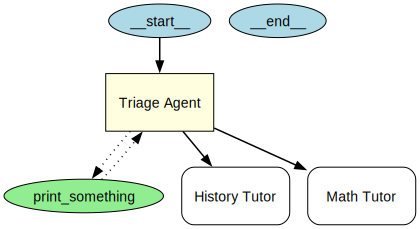

In [208]:
draw_graph(triage_agent)

## Common Agent Patterns

# Deep Research System